In [84]:
from builtins import sorted

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('./US-pumpkins.csv')

pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [85]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]
columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2
date_series = pd.to_datetime(pumpkins['Date'], format='%m/%d/%y')
month = date_series.dt.month
day_of_year = date_series.apply(lambda dt: (dt - datetime(dt.year, 1, 1)).days)

new_pumpkins = pd.DataFrame({
    'Month': month, 
    'Day Of Year': day_of_year, 
    'Variety': pumpkins['Variety'], 
    'City': pumpkins['City Name'], 
    'Package': pumpkins['Package'], 
    'Low Price': pumpkins['Low Price'],
    'High Price': pumpkins['High Price'], 
    'Price': price
})

In [86]:
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price / (1 + 1 / 9)
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price / (1 / 2)

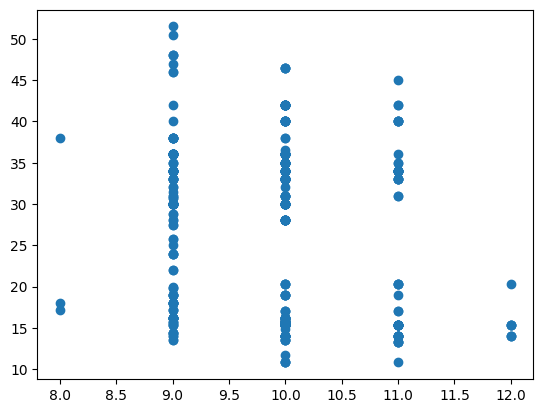

In [87]:
plt.scatter('Month','Price',data=new_pumpkins)

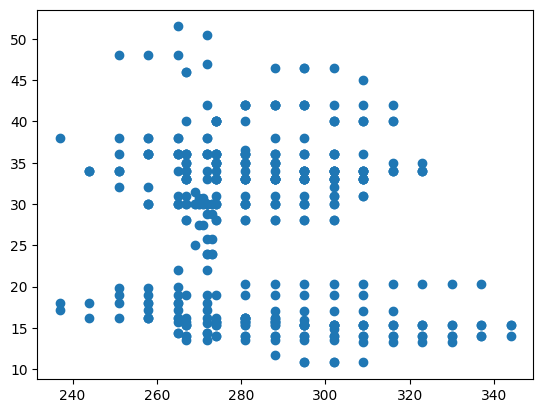

In [88]:
plt.scatter('Day Of Year','Price',data=new_pumpkins)

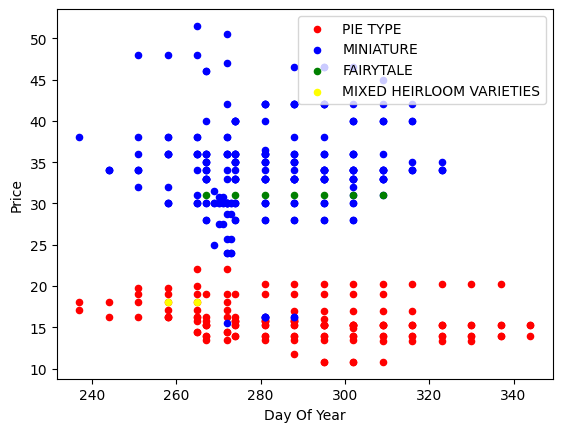

In [89]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('Day Of Year','Price',ax=ax,c=colors[i],label=var)

<Axes: xlabel='Variety'>

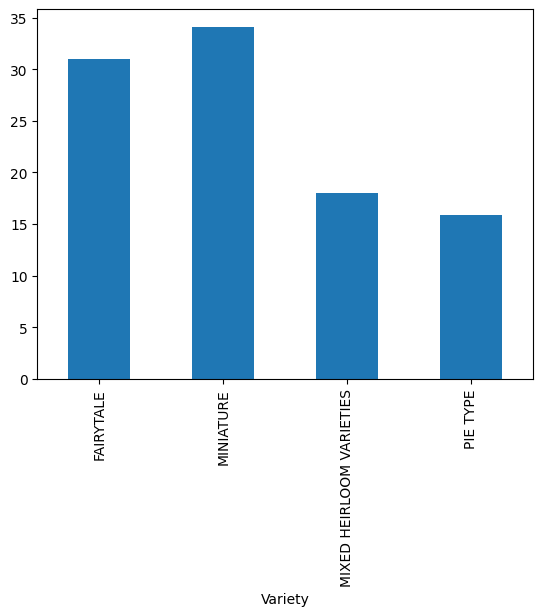

In [90]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<Axes: xlabel='Day Of Year', ylabel='Price'>

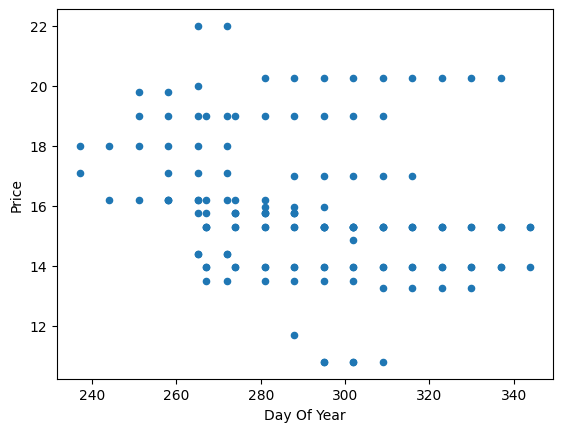

In [91]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE'].copy()
pie_pumpkins.plot.scatter('Day Of Year','Price') 

In [92]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        144 non-null    int32  
 1   Day Of Year  144 non-null    int64  
 2   Variety      144 non-null    object 
 3   City         144 non-null    object 
 4   Package      144 non-null    object 
 5   Low Price    144 non-null    float64
 6   High Price   144 non-null    float64
 7   Price        144 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 9.6+ KB


In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [94]:
X = pie_pumpkins['Day Of Year'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [95]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

LinearRegression()

In [96]:
pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

Mean error: 2.76 (17.3%)


In [97]:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.04499342423558461


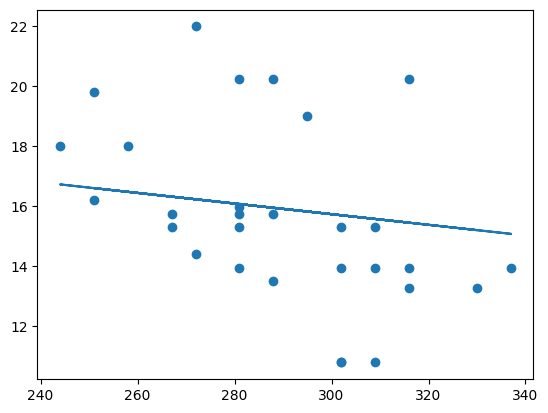

In [98]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

In [99]:
print(f"y = {lin_reg.coef_[0]}x + {lin_reg.intercept_}")

y = -0.017724513173649845x + 21.060699786044474


In [100]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [101]:
pred_2 = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, pred_2))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred_2)*100:3.3}%)')

Mean error: 2.73 (17.2%)


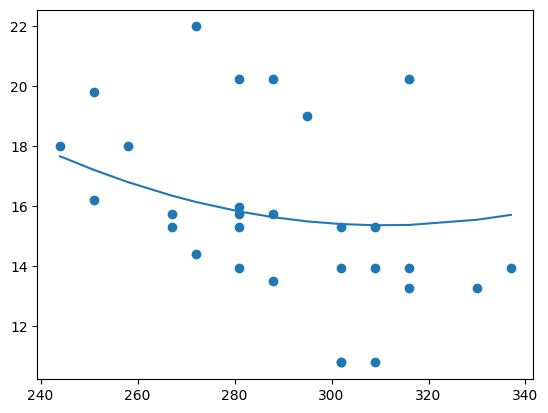

In [102]:
plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

In [103]:
score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.07486289050738915


In [104]:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,False,False,False,True
71,False,False,False,True
72,False,False,False,True
73,False,False,False,True
74,False,False,False,True
...,...,...,...,...
1738,False,True,False,False
1739,False,True,False,False
1740,False,True,False,False
1741,False,True,False,False


In [105]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [107]:
pred_3 = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred_3))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred_3)*100:3.3}%)')

Mean error: 2.23 (8.28%)


In [108]:
score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.9658747228525119


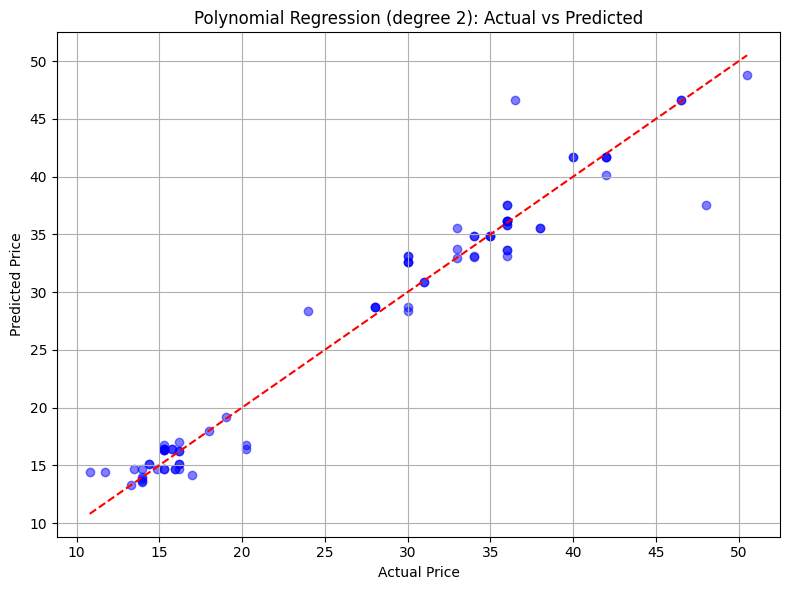

In [109]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_3, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y = x line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Polynomial Regression (degree 2): Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

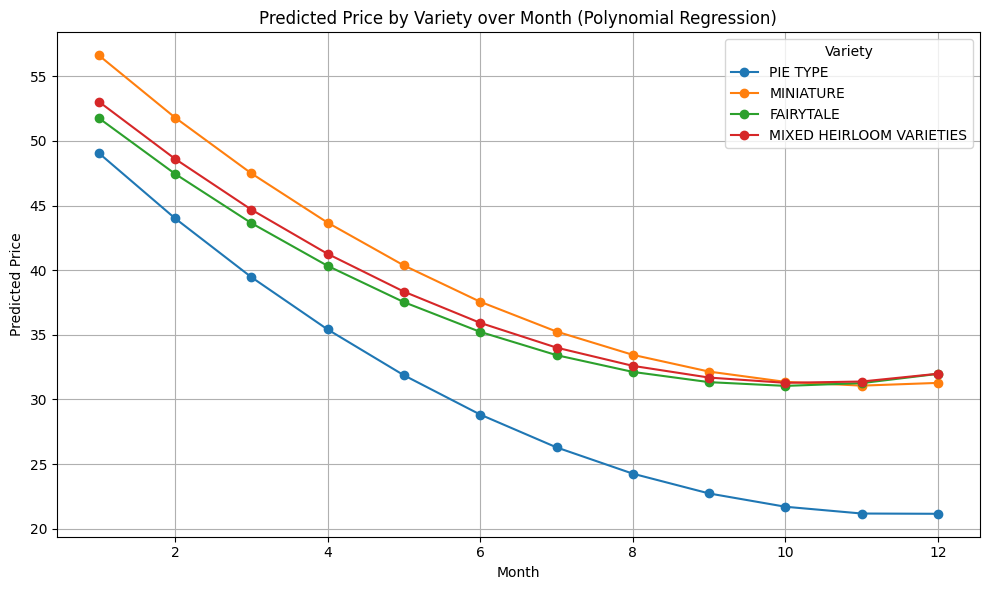

In [111]:
# Prepare range for X axis (Month: 1–12)
months = np.arange(1, 13)

# Prepare varieties (you can limit to top N if too many)
varieties = new_pumpkins['Variety'].unique()[:4]  # choose top 4 for clarity

plt.figure(figsize=(10, 6))

for var in varieties:
    preds = []
    for month in months:
        # Base input row
        row = pd.get_dummies(new_pumpkins['Variety']).mean().to_frame().T
        row.loc[:, :] = 0  # reset all to zero
        if var in row.columns:
            row[var] = 1  # set this variety

        # Add Month
        row = row.join(pd.DataFrame({'Month': [month]}))

        # Add City dummies (use mean values)
        row = row.join(pd.get_dummies(new_pumpkins['City']).mean().to_frame().T)

        # Add Package dummies (use mean values)
        row = row.join(pd.get_dummies(new_pumpkins['Package']).mean().to_frame().T)

        # Ensure all columns exist and match training set
        for col in X.columns:
            if col not in row.columns:
                row[col] = 0
        row = row[X.columns]  # correct order

        # Predict
        pred = pipeline.predict(row)[0]
        preds.append(pred)

    # Plot this variety
    plt.plot(months, preds, marker='o', label=var)

plt.title("Predicted Price by Variety over Month (Polynomial Regression)")
plt.xlabel("Month")
plt.ylabel("Predicted Price")
plt.legend(title='Variety')
plt.grid(True)
plt.tight_layout()
plt.show()